In [1]:
# === Dipendenze ===
import warnings
warnings.filterwarnings("ignore")

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import osmnx as ox

try:
    import contextily as ctx
    HAS_CTX = True
except Exception:
    HAS_CTX = False

ox.settings.use_cache = True
ox.settings.log_console = False
ox.settings.timeout = 180

In [2]:
# === Parametri ===
PARAMS = {
    "center_latlon": (41.940583, 12.418912),  # Santa Maria della Pietà
    "dist_m": 5000,                           # raggio in metri
    "crs_metric": "EPSG:32633",               # UTM 33N
    "use_basemap": True,                      # usa basemap CartoDB se contextily disponibile
}

In [3]:


# === AOI: buffer metrico attorno al punto ===
lat, lon = PARAMS["center_latlon"]
gdf_pt = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326)
aoi_m = gdf_pt.to_crs(PARAMS["crs_metric"]).buffer(PARAMS["dist_m"])
aoi = aoi_m.to_crs(4326).iloc[0]                   # polygon in WGS84 per query
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi], crs=4326)

# === Tag “verde” da OSM ===
tags = {
    "leisure":  ["park", "garden", "recreation_ground", "nature_reserve", "golf_course"],
    "landuse":  ["grass", "forest", "recreation_ground", "meadow", "orchard", "vineyard"],
    "natural":  ["wood", "grassland", "heath", "scrub", "wetland"],
    "boundary": ["protected_area"],
}

# === Download geometrie OSM (compat v1/v2) ===
if hasattr(ox, "features_from_polygon"):          # OSMnx v2.x
    gdf = ox.features_from_polygon(aoi, tags=tags)
else:                                             # OSMnx v1.x
    gdf = ox.geometries_from_polygon(aoi, tags=tags)

# Tieni solo poligoni
gdf = gdf[gdf.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
# Clip all'AOI
gdf = gpd.clip(gdf, aoi_gdf)

# Categoria (macro-chiave)
def pick_cat(row):
    for c in ["leisure", "landuse", "natural", "boundary"]:
        v = row.get(c)
        if isinstance(v, str) and v:
            return f"{c}:{v}"
    return "other"

gdf["category"] = gdf.apply(pick_cat, axis=1)

# === Plot (Web Mercator per basemap) ===
gdf3857 = gdf.to_crs(3857)
aoi3857 = aoi_gdf.to_crs(3857)

# --- ACQUE: poligoni e linee (OSM) ---
water_tags_poly = {
    "natural": ["water", "wetland"],
    "landuse": ["reservoir", "basin"],
    "water": ["lake", "pond", "reservoir", "river", "canal"]
}
water_tags_line = {
    "waterway": ["river", "stream", "canal", "ditch", "drain"]
}

# Poligoni d'acqua
if hasattr(ox, "features_from_polygon"):
    water_poly = ox.features_from_polygon(aoi, tags=water_tags_poly)
else:
    water_poly = ox.geometries_from_polygon(aoi, tags=water_tags_poly)

# Tieni solo poligoni/multipoligoni e clippa
water_poly = water_poly[water_poly.geometry.type.isin(["Polygon", "MultiPolygon"])].copy()
water_poly = gpd.clip(water_poly, aoi_gdf)
water_poly3857 = water_poly.to_crs(3857)

# Linee d'acqua
if hasattr(ox, "features_from_polygon"):
    water_line = ox.features_from_polygon(aoi, tags=water_tags_line)
else:
    water_line = ox.geometries_from_polygon(aoi, tags=water_tags_line)

# Tieni solo LineString/MultiLineString e clippa
water_line = water_line[water_line.geometry.type.isin(["LineString", "MultiLineString"])].copy()
water_line = gpd.clip(water_line, aoi_gdf)
water_line3857 = water_line.to_crs(3857)

# --- FILTRO: tieni solo corsi d'acqua visibili (fiumi e canali, non sotterranei) ---
if "waterway" in water_line.columns:
    def is_visible_water(row):
        tipo = str(row.get("waterway", ""))
        tunnel = str(row.get("tunnel", ""))
        layer = str(row.get("layer", ""))
        return (tipo in ["river", "canal"]) and (tunnel != "yes") and (layer not in ["-1", "-2"])
    
    water_line_visible = water_line[water_line.apply(is_visible_water, axis=1)].copy()
    water_line3857 = water_line_visible.to_crs(3857)
else:
    # fallback: se manca la colonna, lascio tutto
    water_line_visible = water_line


# Stili acqua
WATER_FILL = "#4aa3df"   # azzurro poligoni
WATER_EDGE = "#2c7fb8"   # bordo poligoni
WATER_LINE = "#2c7fb8"   # linee fiumi/rogge

# --- Opzioni layer leggeri ---
SHOW_ROADS = True
SHOW_LANDUSE_OUTLINES = True      # contorni sottili e tratteggiati
SHOW_LANDUSE_CENTROIDS = False    # alternative: puntini ai centroidi

# --- STRADE (rete "drive" nell'AOI) ---
try:
    # OSMnx v1/v2: stessa API
    G = ox.graph_from_polygon(aoi, network_type="drive", simplify=True)
    edges = ox.graph_to_gdfs(G, nodes=False, edges=True)
    edges3857 = edges.to_crs(3857)

    # tiene solo le categorie principali
    MAJOR = {"motorway","trunk","primary","secondary","tertiary"}
    def is_major(hw):
        if hw is None: 
            return False
        if isinstance(hw, (list, set, tuple)):
            return any(h in MAJOR for h in hw)
        return hw in MAJOR
    edges_major3857 = edges3857[edges3857["highway"].apply(is_major)].copy()
except Exception:
    edges_major3857 = gpd.GeoDataFrame(geometry=[], crs=3857)

# --- LANDUSE: contorni/centroidi leggeri ---
landuse_gdf = gdf.loc[gdf["landuse"].notna()].copy()
landuse3857 = landuse_gdf.to_crs(3857)
landuse_centroids3857 = landuse3857.copy()
landuse_centroids3857["geometry"] = landuse_centroids3857.geometry.centroid


palette = {
    "leisure":  "#6FD08C",
    "landuse":  "#9BE37D",
    "natural":  "#4DAA57",
    "boundary": "#B1EAAE",
    "other":    "#A9E0A4",
}
def top_key(cat): return cat.split(":")[0] if isinstance(cat, str) and ":" in cat else "other"
colors = gdf3857["category"].apply(lambda c: palette.get(top_key(c), palette["other"]))



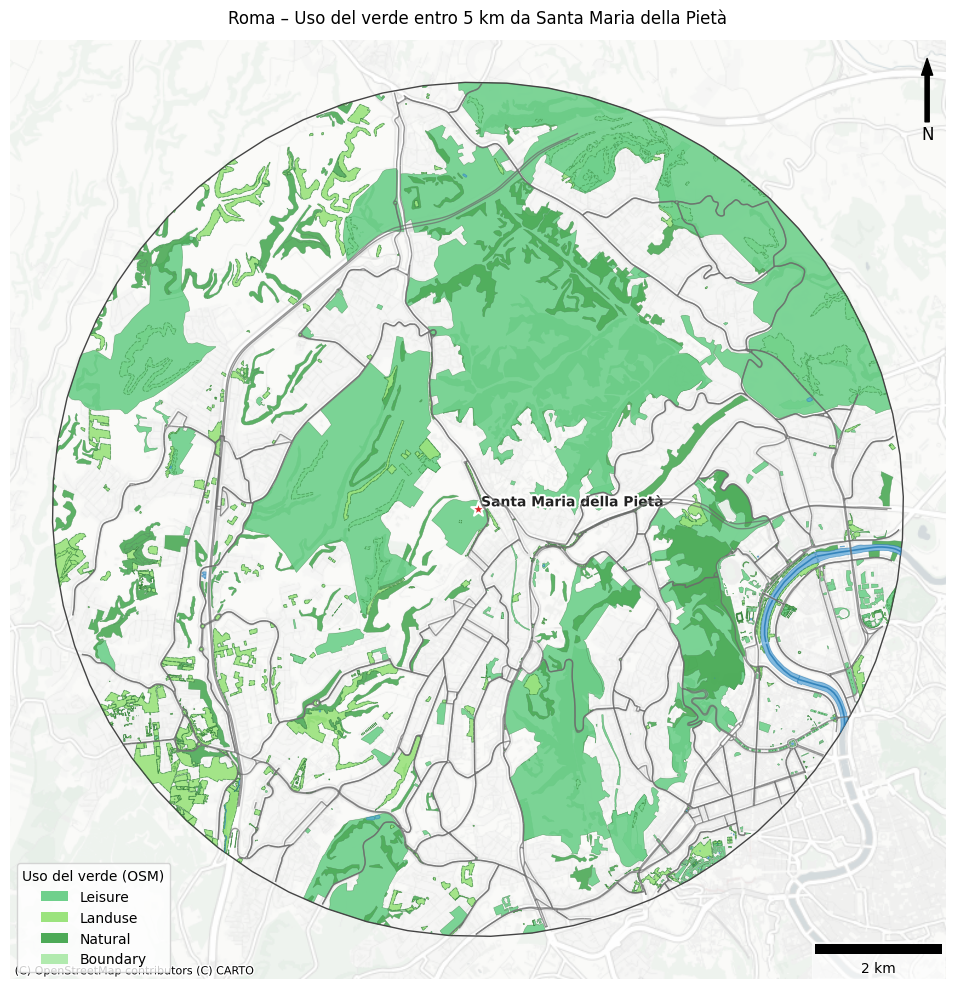

Creato file: mappa_verde_smdp.png


In [4]:
fig, ax = plt.subplots(figsize=(10,10))
aoi3857.boundary.plot(ax=ax, color="#444444", linewidth=1.0)
gdf3857.plot(ax=ax, color=colors, edgecolor="#4F8F59", linewidth=0.3, alpha=0.9)

# --- ACQUE: poligoni (zone acquatiche) ---
if not water_poly3857.empty:
    water_poly3857.plot(
        ax=ax, facecolor=WATER_FILL, edgecolor=WATER_EDGE,
        linewidth=0.6, alpha=0.6, zorder=6
    )

# --- ACQUE: linee (fiumi, canali) ---
if not water_line3857.empty:
    water_line3857.plot(
        ax=ax, color=WATER_LINE, linewidth=1.2, alpha=0.9, zorder=7
    )

# === Marker per Santa Maria della Pietà ===
import matplotlib.patheffects as pe
from shapely.geometry import Point

# Punto di riferimento
lat, lon = PARAMS["center_latlon"]
point_wgs84 = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=4326)
point_3857 = point_wgs84.to_crs(3857)

# Disegna marker rosso con bordo bianco
ax.scatter(
    point_3857.geometry.x,
    point_3857.geometry.y,
    s=120, marker='*', color='#d62828', edgecolor='white', linewidth=1.5, zorder=5
)

# Etichetta elegante accanto
for x, y in zip(point_3857.geometry.x, point_3857.geometry.y):
    ax.text(
        x + 50, y + 50, "Santa Maria della Pietà",
        fontsize=10, fontweight='bold', color='#222222',
        path_effects=[pe.withStroke(linewidth=3, foreground="white")],
        zorder=6
    )

# --- STRADE PRINCIPALI (sottili, leggere) ---
if SHOW_ROADS and not edges_major3857.empty:
    edges_major3857.plot(
        ax=ax, linewidth=1.0, alpha=0.7, color="#6b6b6b", zorder=7
    )

# --- LANDUSE: contorni tratteggiati molto leggeri ---
if SHOW_LANDUSE_OUTLINES and not landuse3857.empty:
    landuse3857.boundary.plot(
        ax=ax, linewidth=0.6, linestyle="--", alpha=0.5, color="#2e7d32", zorder=6
    )

# --- LANDUSE: centroidi (alternativa super-leggera) ---
if SHOW_LANDUSE_CENTROIDS and not landuse_centroids3857.empty:
    ax.scatter(
        landuse_centroids3857.geometry.x, landuse_centroids3857.geometry.y,
        s=8, marker='o', color="#2e7d32", alpha=0.6, zorder=6
    )


if PARAMS["use_basemap"] and HAS_CTX:
    try:
        ctx.add_basemap(ax, crs=gdf3857.crs, source=ctx.providers.CartoDB.PositronNoLabels)
    except Exception:
        pass

from matplotlib.patches import Patch
handles = [Patch(facecolor=palette[k], edgecolor="none", label=k.capitalize())
           for k in ["leisure","landuse","natural","boundary"]]
ax.legend(handles=handles, loc="lower left", title="Uso del verde (OSM)")

ax.set_axis_off()
ax.set_title("Roma – Uso del verde entro 5 km da Santa Maria della Pietà", pad=12)

import matplotlib_scalebar.scalebar as sb
from matplotlib.patches import FancyArrow

# Barra scala
scalebar = sb.ScaleBar(1, units="m", dimension="si-length", location="lower right", box_alpha=0.6)
ax.add_artist(scalebar)

# Freccia nord (semplice)
x, y, arrow_length = 0.98, 0.98, 0.08
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=8),
            ha='center', va='center', fontsize=12,
            xycoords=ax.transAxes)


plt.tight_layout()
plt.savefig("mappa_verde_smdp.png", dpi=200, bbox_inches="tight")
plt.show()

print("Creato file: mappa_verde_smdp.png")
